In [1]:
### 1
# Import and load the packages we will need. 
# You will probably need to install ipywidgets and bokeh
# conda install -c https://conda.anaconda.org/anaconda ipywidgets
# conda install -c https://conda.anaconda.org/anaconda bokeh

%matplotlib inline
import matplotlib.pyplot as plt
import collections
import gzip
import numpy as np
import os
import phate
import time

import pandas as pd

from ipywidgets import interact
import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.palettes import Category20b

from collections import defaultdict
import itertools

# To install sklearn: conda install scikit-learn
import sklearn
from sklearn import decomposition
from sklearn.decomposition import PCA as PCA # We'll use this to check our implementation
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as mTSNE

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS

import umap

In [2]:
import sklearn

In [3]:
parent_dir = '/Users/alex/Documents/Ethnicity'

In [4]:
### 16
from collections import Counter # We'll use this built-in function to count genotypes.

class snp(object):

    def __init__(self, line, select=False, autosome_only =True):
        """The initialization method takes in a line from the vcf file, as a string, 
        and records the relevant information. 
        line: a string from a vcf file
        select: a list of positions of individuals to be analyzed, where positions run from 0 to 
        nInd-1, the number of individuals
        """ 
        
        split_line = line.split()  #  First break down the line into a list of each field
        
        self.failed = False  # A label that we will set to True if something goes wrong.
        
        if line.startswith('#'):
            self.failed = True
            self.failure_cause = "line was a header line, not a snp"
            return
        
        if len(split_line)<=5:
            self.failed = True
            self.failure_cause = "incorrectly formatted line, should have at least 5 fields " + line
            return
          
        self.chrom = split_line[0]
        if autosome_only:
            if self.chrom not in ["%d" % (i,) for i in range(1,23)]:
                self.failed = True
                self.failure_cause = "not recognized as an autosome while autosome_only set to True"
                return
        
        self.chrom = int(split_line[0]) # Chromosome (numbered)
        self.position = int(split_line[1])  # The coordinates of the snp
        self.rid = split_line[2] # Name/Record ID
        self.ref_allele = split_line[3]
        self.alt_allele = split_line[4] # The alterate allele according to the vcf; also a string 
        # Only accept snps in ACGT. 
        if self.ref_allele not in ["A","C","G","T"] or self.alt_allele not in ["A","C","G","T"]:
            self.failed = True
            self.failure_cause = "ref or alt not in ACGT"
            return
        self.filter = split_line[6]  # See vcf format specifications for the interpretation of 
                                    # the filter field
        if self.filter not in ['PASS', '.'] :  # PASS indicates a SNP that passed all QC filters.
            self.failed = True
            self.failure_cause = self.filter
            return
        
        
        self.genotype_strings = split_line[9:]


        # Prepare a list that will contain the transformed genotypes. 
        # Since we already know how long the list will be, it makes sense 
        # to create an array of zeros of the same length as self.gtypes, 
        
        self.genotype_array = np.zeros(len(self.genotype_strings), dtype = np.int8)             

        # Count the number of each genotype. 
        # There may be different strings giving the same genotype so we increment the 
        # counts found so far for the genotype by the number of times the  
        # For example, "0/0" and "0\0" give homref, and "0|1" and "1|0" give het
        
        n_missing = 0
        for index,genotype_string in enumerate(self.genotype_strings):
            if genotype_string == './.':
                n_missing +=1 
                self.genotype_array[index]=-1
                continue # missing data will be left as 0
            allele_0 = genotype_string[0] # Get the first allele (as a string)
            allele_1 = genotype_string[2]
            if (allele_0=='1' and allele_1=='1'): # Use rstrip because windows machines will occasionally have extra \n
                self.genotype_array[index]=2
            elif ((allele_0=='0' and allele_1=='1') or (allele_0=='1' and allele_1=='0')):
                self.genotype_array[index]=1   
            elif (allele_0=='0' and allele_1=='0'):
                # The array was initialized to zero, so nothing to do here!
                continue
            else:
                print(("unknown genotype", genotype_string))
                self.failed=True
                self.failedreason="unknown genotype"
                return

In [5]:
### 17
# the vcf file can be found at 
#http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/hd_genotype_chip/
 
vcf_file_name = 'ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz'
#vcf_file = os.path.join(parent_dir, vcf_file_name)
vcf_file = '/Volumes/Stockage/alex/1000G/ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz'

In [6]:
### 18
start_time = time.time()
number_of_lines_to_skip = 10 # Number_of_lines_to_skip each time we process a line. This allows us to get 
                              # a genome-wide sample without having to store all the lines in memory.

genotype_matrix = []  # Will contain our numerical genotype matrix. 
genotype_positions = []
genotype_names = []
x = 0
error_count = 0

with gzip.open(vcf_file,'rt') as f:
    count = 0
    for line in f:
        count+=1
        if count % number_of_lines_to_skip == 0:
            if line.startswith("#") or snp(line).failed:
                if snp(line).failure_cause != "line was a header line, not a snp":
                    error_count += 1
                    if x < 10:
                        print('Failed: ' + snp(line).failure_cause)
                        x+=1
                continue
            
            return_snp = snp(line)
            genotype_matrix.append(return_snp.genotype_array)
            genotype_names.append(return_snp.rid)
            genotype_positions.append([return_snp.chrom, return_snp.position])

end_time = time.time()
            
print(count, error_count)
print(len(genotype_matrix))
print(str(end_time - start_time))

Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
Failed: not recognized as an autosome while autosome_only set to True
905886 3715
86864
261.91826701164246


In [7]:
transposed_genotype_matrix = np.array(genotype_matrix).transpose()
print(transposed_genotype_matrix, transposed_genotype_matrix.shape)

[[ 0  2  0 ...,  2  0  0]
 [-1  2  0 ...,  0  0  0]
 [ 0  2  0 ...,  2  0  1]
 ..., 
 [ 0  2  0 ...,  1  0  1]
 [ 0  2  0 ...,  0  1  0]
 [ 0  2  0 ...,  2  1  0]] (3450, 86864)


In [8]:
population_file_name = 'affy_samples.20141118.panel' # This file is available at 
#http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/hd_genotype_chip/

population_file = os.path.join(parent_dir, population_file_name)

population_by_individual = defaultdict(int)
individuals_by_population = defaultdict(list)  # A dictionary containing all the individuals in a given population

for line in open(population_file,'r'):
    split_line = line.split()
    if split_line[0] == 'sample':  # header line
        continue

    sample_name = split_line[0]
    population_name = split_line[1]
    population_by_individual[sample_name] = population_name
    individuals_by_population[population_name].append(sample_name) 

populations = list(individuals_by_population.keys())
print(populations)

['GBR', 'FIN', 'CHS', 'PUR', 'CDX', 'CLM', 'IBS', 'PEL', 'PJL', 'KHV', 'ACB', 'GWD', 'ESN', 'BEB', 'MSL', 'STU', 'ITU', 'CEU', 'YRI', 'CHB', 'JPT', 'LWK', 'ASW', 'MXL', 'TSI', 'GIH']


In [9]:
# The path to the place where you put the population name file.
population_description_file = os.path.join(parent_dir, "20131219.populations.tsv")

name_by_code = {}  # A dictionary giving the full name of each population code
pop_by_continent = {}  # A dictionary giving the code of each population within a continent  
continent_by_population = {}  # A dictionary giving the continent for each population code
for line in open(population_description_file,'r'):
    split_line = line.split('\t')
    if split_line[0] in ['Population Description','Total','']:  # header or footer
        continue
    name_by_code[split_line[1]] = split_line[0]
    continent_by_population[split_line[1]] = split_line[2]
    try: 
        pop_by_continent[split_line[2]].append(split_line[1])
    except KeyError:
        pop_by_continent[split_line[2]] = [split_line[1]]

continents = list(pop_by_continent.keys()) 

print("\n\ncontinent groupings\n\n")
for continent in continents:
    print(continent, pop_by_continent[continent])
    
    
# Finally, we want a list of populations listed by continent. 
pops=[]
for continent in continents:
    pops.extend(pop_by_continent[continent])
print("\n\nPopulation labels\n\n")

for pop in pops:
    print(pop, name_by_code[pop])



continent groupings


EAS ['CDX', 'CHB', 'JPT', 'KHV', 'CHS']
SAS ['BEB', 'GIH', 'ITU', 'PJL', 'STU']
AFR ['ASW', 'ACB', 'ESN', 'GWD', 'LWK', 'MSL', 'YRI']
EUR ['GBR', 'FIN', 'IBS', 'TSI', 'CEU']
AMR ['CLM', 'MXL', 'PEL', 'PUR']


Population labels


CDX Chinese Dai in Xishuangbanna, China
CHB Han Chinese in Bejing, China
JPT Japanese in Tokyo, Japan
KHV Kinh in Ho Chi Minh City, Vietnam
CHS Southern Han Chinese, China
BEB Bengali in Bangladesh
GIH Gujarati Indian in Houston,TX
ITU Indian Telugu in the UK
PJL Punjabi in Lahore,Pakistan
STU Sri Lankan Tamil in the UK
ASW African Ancestry in Southwest US
ACB African Caribbean in Barbados
ESN Esan in Nigeria
GWD Gambian in Western Division
LWK Luhya in Webuye, Kenya
MSL Mende in Sierra Leone
YRI Yoruba in Ibadan, Nigeria
GBR British in England and Scotland
FIN Finnish in Finland
IBS Iberian populations in Spain
TSI Toscani in Italy
CEU Utah residents with N and W European ancestry
CLM Colombian in Medellin, Colombia
MXL Mexican Ancestry

In [11]:
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy

color_dict = {}
for i, cont in enumerate(continents): 
    for j, pop in enumerate(pop_by_continent[cont]):
        color_dict[pop] = Category20b[20][4*i+j%4]

# Issue: shared colours between:
# CDX and CHS (purple)
# GIH and STU (green)
# ASW and LWK (brown/yellow)
# ACB and MSL (brown/yellow)
# ESN and YRI (goldenrod/canary/saffron/paella)
# GBR and CEU (dark red)

# Manually assign colours to CHS, STU, LWK, MSL, CEU
color_dict['CHS'] = Purples[9][4]# purple
color_dict['STU'] = Greens[9][6] # green
color_dict['LWK'] = PuOr[11][-1] # brown
color_dict['MSL'] = PuOr[11][-2] # rusty brown
color_dict['YRI'] = PuOr[11][-3] # cappucino w/ extra milk (stirred)
color_dict['CEU'] = RdGy[11][-3]

In [12]:
# For troubleshooting purposes (checking individual values of colours)

#for i, cont in enumerate(continents):
#    for j, pop in enumerate(pop_by_continent[cont]):
#        print(str(i), str(j), cont, color_dict[pop], pop, name_by_code[pop])

In [13]:
### 27
# Get the path to the file containing the vcf header. 
# That should be the same vcf you used above, but if your filtered file
# is somehow missing the header, you can aways look at the initial file that still has the header.
x=0

vcf_file = '/Volumes/Stockage/alex/1000G/ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz'
for line in gzip.open(vcf_file,'rt'):
    if line.startswith("#"):
        if not line.startswith("##"):
            # Extract the individuals for the population, as a list of strings
            # Make sure you don't have trailing \n if you're running windows!
            individuals = line.split()[9:]
            # Once we've extracted the individuals, we can exit the loops. 
            break

In [14]:
### 28
# Build a list of populations for each indiviudal in the vcf file
lspop = []
for ind in individuals:
    pop = population_by_individual[ind]
    if pop == 0:
        #print(0)
        lspop.append("missing")
    else:
        lspop.append(pop)

        
indices_of_population_members = defaultdict(list)

for index,individual in enumerate(individuals):
    try:
        indices_of_population_members[population_by_individual[individual]].append(index)
    except KeyError: # We do not have population info for this individual
        continue

#indices_of_population_members

In [15]:
pop_by_continent

{'AFR': ['ASW', 'ACB', 'ESN', 'GWD', 'LWK', 'MSL', 'YRI'],
 'AMR': ['CLM', 'MXL', 'PEL', 'PUR'],
 'EAS': ['CDX', 'CHB', 'JPT', 'KHV', 'CHS'],
 'EUR': ['GBR', 'FIN', 'IBS', 'TSI', 'CEU'],
 'SAS': ['BEB', 'GIH', 'ITU', 'PJL', 'STU']}

In [16]:
color_dict

{'ACB': '#bd9e39',
 'ASW': '#8c6d31',
 'BEB': '#637939',
 'CDX': '#393b79',
 'CEU': '#d6604d',
 'CHB': '#5254a3',
 'CHS': '#9e9ac8',
 'CLM': '#7b4173',
 'ESN': '#e7ba52',
 'FIN': '#ad494a',
 'GBR': '#843c39',
 'GIH': '#8ca252',
 'GWD': '#e7cb94',
 'IBS': '#d6616b',
 'ITU': '#b5cf6b',
 'JPT': '#6b6ecf',
 'KHV': '#9c9ede',
 'LWK': '#7f3b08',
 'MSL': '#b35806',
 'MXL': '#a55194',
 'PEL': '#ce6dbd',
 'PJL': '#cedb9c',
 'PUR': '#de9ed6',
 'STU': '#c7e9c0',
 'TSI': '#e7969c',
 'YRI': '#e08214'}

In [17]:
%store continents
%store pop_by_continent
%store pop
%store indices_of_population_members
%store name_by_code
%store continent_by_population
%store individuals
%store population_by_individual
%store individuals_by_population
%store populations
%store color_dict

Stored 'continents' (list)
Stored 'pop_by_continent' (dict)
Stored 'pop' (str)
Stored 'indices_of_population_members' (defaultdict)
Stored 'name_by_code' (dict)
Stored 'continent_by_population' (dict)
Stored 'individuals' (list)
Stored 'population_by_individual' (defaultdict)
Stored 'individuals_by_population' (defaultdict)
Stored 'populations' (list)
Stored 'color_dict' (dict)


# Principal component generation

Generate the PCs

In [ ]:
pca_full = PCA().fit(transposed_genotype_matrix)

In [ ]:
np.savetxt(pca_full.components_, '/Users/alex/Documents/Ethnicity/1kgp_components')

In [54]:
pca_full.components_.shape

NameError: name 'pca_full' is not defined

In [20]:
#%store pca_full
%store transposed_genotype_matrix

Stored 'transposed_genotype_matrix' (ndarray)


In [52]:
# Calculate the PCs manually. We want a subset of k PCs
# Have to subset the components and use that.
k = 100
comps = pca_full.components_[:k,:]

NameError: name 'pca_full' is not defined

In [63]:
# Mean-center the SNP data and then transform it (projecting to k dimensions)
projections_to_PCs = np.dot((transposed_genotype_matrix - pca_full.mean_), comps.T)

In [49]:
np.savetxt('/Volumes/Stockage/alex/1000G/projections/pca_1000g_100', projections_to_PCs)

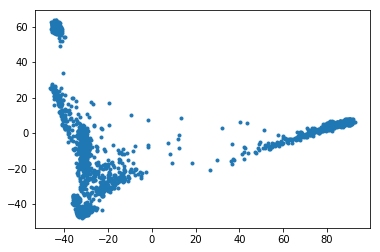

In [90]:
plt.plot(projections_to_PCs[:,1], projections_to_PCs[:,2], '.')

In [20]:
pca_100 = np.loadtxt('/Volumes/Stockage/alex/1000G/projections/pca_1000g_100')

# Secondary dimension reduction methods

Test a variety of other secondary reduction measures and see what sticks.

Conclusion: MDS has some potential but still doesn't do as well as TSNE. It did split Japan into two subclusters though....

In [ ]:
# Create an MDS projection for PCs 11 through 30.
mds_proj_list = list()

for pc_proj in pc_proj_list:
    if 10<=pc_proj.shape[1]<=30:
        temp_proj = MDS(n_components=2).fit_transform(pc_proj)
        np.savetxt('1000G_MDS_PC_' + str(pc_proj.shape[1]), temp_proj)

In [88]:
# Try t-SNE (2 dimensions)
genotype_tsne = TSNE(n_components=2).fit_transform(projections_to_PCs)

In [26]:
# Try PHATE
# Based off of:
# https://nbviewer.jupyter.org/github/KrishnaswamyLab/PHATE/blob/master/Python/test/phate_examples.ipynb?flush_cache=true
?phate.PHATE

# Create instance of PHATE operator (use default options)
phate_operator = phate.PHATE()

# Run PHATE with classic MDS on the projected data as well as the unprojected data
Y_cmds_raw = phate_operator.fit_transform(transposed_genotype_matrix)
Y_cmds_pcs = phate_operator.fit_transform(projections_to_PCs)

# Run PHATE with metric MDS on each one
phate_operator.reset_mds(mds="metric")
Y_mmds_raw = phate_operator.fit_transform(transposed_genotype_matrix)
Y_mmds_pcs = phate_operator.fit_transform(projections_to_PCs)

# Run PHATE with non-metric MDS on each one
phate_operator.reset_mds(mds="nonmetric")
Y_nmmds_raw = phate_operator.fit_transform(transposed_genotype_matrix)
Y_nmmds_pcs = phate_operator.fit_transform(projections_to_PCs)

Bulding kNN graph and diffusion operator...
Built graph and diffusion operator in 1520.77 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 3.41 seconds.
Embedding data using classic MDS...
Embedded data in 22.78 seconds.
Finished PHATE embedding in 1546.96 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using classic MDS...
Embedded data in 22.31 seconds.
Finished PHATE embedding in 22.31 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using metric MDS...
Embedded data in 929.52 seconds.
Finished PHATE embedding in 929.52 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using metric MDS...
Embedded data in 924.02 seconds.
Finished PHATE embedding in 924.02 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embe

In [49]:
# Try out PHATE on other PC embeddings.
phate_operator.reset_mds(mds="nonmetric")

nmmds_pcs = []

for i in range(1, 15):
    temp_comps = pca_full.components_[:i*10,:]
    temp_pc_projection = np.dot((transposed_genotype_matrix - pca_full.mean_), temp_comps.T)
    temp_projection = phate_operator.fit_transform(temp_pc_projection)
    nmmds_pcs.append(temp_projection)

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 53.97 seconds.
Finished PHATE embedding in 53.97 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 1028.05 seconds.
Finished PHATE embedding in 1028.05 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 30480.76 seconds.
Finished PHATE embedding in 30480.76 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 2569.61 seconds.
Finished PHATE embedding in 2569.61 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 2353.35 seconds.
Finished PHATE embedding in 2353.35 seconds.

Using p

KeyboardInterrupt: 

In [51]:
# MDS (skipping the PHATE bit)
mds_raw = MDS().fit_transform(transposed_genotype_matrix)
mds_pc30 = MDS().fit_transform(projections_to_PCs)

In [90]:
mds_pcs = []

for p in pc_list:
    #temp_comps = pca_full.components_[:i*10,:]
    #temp_pc_projection = np.dot((transposed_genotype_matrix - pca_full.mean_), temp_comps.T)
    temp_projection = MDS().fit_transform(p)
    mds_pcs.append(temp_projection)
    print("Finished with MDS projection of " + str(p.shape[1]) + " PCs")

Finished with MDS projection of 10 PCs
Finished with MDS projection of 20 PCs
Finished with MDS projection of 30 PCs
Finished with MDS projection of 40 PCs
Finished with MDS projection of 50 PCs
Finished with MDS projection of 60 PCs
Finished with MDS projection of 70 PCs
Finished with MDS projection of 80 PCs
Finished with MDS projection of 90 PCs
Finished with MDS projection of 100 PCs
Finished with MDS projection of 110 PCs
Finished with MDS projection of 120 PCs
Finished with MDS projection of 130 PCs
Finished with MDS projection of 140 PCs
Finished with MDS projection of 150 PCs
Finished with MDS projection of 160 PCs
Finished with MDS projection of 170 PCs
Finished with MDS projection of 180 PCs
Finished with MDS projection of 190 PCs
Finished with MDS projection of 200 PCs
Finished with MDS projection of 210 PCs
Finished with MDS projection of 220 PCs
Finished with MDS projection of 230 PCs
Finished with MDS projection of 240 PCs
Finished with MDS projection of 250 PCs


In [102]:
for p in range(0, len(pc_list)):
    plot_bokeh(mds_pcs[p], 'MDS on ' + str(pc_list[p].shape[1]) + 'PCs', 'MDS_' + str(pc_list[p].shape[1]) + 'PC',
               'MDS with ' + str(pc_list[p].shape[1]) + 'PCs')
    print("Finished creating interactive HTML for MDS with " + str(pc_list[p].shape[1]) + " PCs")

Finished creating interactive HTML for MDS with 10 PCs
Finished creating interactive HTML for MDS with 20 PCs
Finished creating interactive HTML for MDS with 30 PCs
Finished creating interactive HTML for MDS with 40 PCs
Finished creating interactive HTML for MDS with 50 PCs
Finished creating interactive HTML for MDS with 60 PCs
Finished creating interactive HTML for MDS with 70 PCs
Finished creating interactive HTML for MDS with 80 PCs
Finished creating interactive HTML for MDS with 90 PCs
Finished creating interactive HTML for MDS with 100 PCs
Finished creating interactive HTML for MDS with 110 PCs
Finished creating interactive HTML for MDS with 120 PCs
Finished creating interactive HTML for MDS with 130 PCs
Finished creating interactive HTML for MDS with 140 PCs
Finished creating interactive HTML for MDS with 150 PCs
Finished creating interactive HTML for MDS with 160 PCs
Finished creating interactive HTML for MDS with 170 PCs
Finished creating interactive HTML for MDS with 180 PCs
F

In [105]:
pc_list2 = []
for i in range(1, 10):
    comps = PCA(n_components=i).fit(transposed_genotype_matrix)
    proj = comps.transform(transposed_genotype_matrix)
    pc_list2.append(proj)

mds_pcs2 = []

for p in pc_list2:
    temp_projection = MDS().fit_transform(p)
    mds_pcs2.append(temp_projection)
    print("Finished with MDS projection of" + str(p.shape[1]) + "PCs")

for p in range(0, len(pc_list2)):
    plot_bokeh(mds_pcs2[p], 'MDS on ' + str(pc_list2[p].shape[1]) + 'PCs', 'MDS_' + str(pc_list2[p].shape[1]) + 'PC',
               'MDS with ' + str(pc_list2[p].shape[1]) + 'PCs')
    print("Finished creating interactive HTML for MDS with " + str(pc_list[p].shape[1]) + " PCs")

Finished with MDS projection of1PCs
Finished with MDS projection of2PCs
Finished with MDS projection of3PCs
Finished with MDS projection of4PCs
Finished with MDS projection of5PCs
Finished with MDS projection of6PCs
Finished with MDS projection of7PCs
Finished with MDS projection of8PCs
Finished with MDS projection of9PCs
Finished creating interactive HTML for MDS with 10 PCs
Finished creating interactive HTML for MDS with 20 PCs
Finished creating interactive HTML for MDS with 30 PCs
Finished creating interactive HTML for MDS with 40 PCs
Finished creating interactive HTML for MDS with 50 PCs
Finished creating interactive HTML for MDS with 60 PCs
Finished creating interactive HTML for MDS with 70 PCs
Finished creating interactive HTML for MDS with 80 PCs
Finished creating interactive HTML for MDS with 90 PCs


In [106]:
pc_list_full = pc_list2 + pc_list

In [55]:
# t-SNE transformations
pc_list = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100]
out_dir = '/Volumes/Stockage/alex/1000G/projections'

for p in pc_list:
    temp_projection = TSNE(n_components = 2).fit_transform(projections_to_PCs[:,0:p])
    np.savetxt(os.path.join(out_dir,'1000G_TSNE_PC' + str(p)),temp_projection)
    print("Finished t-SNE projection for " + str(p) + " PCs.")

Finished t-SNE projection for 2 PCs.
Finished t-SNE projection for 3 PCs.
Finished t-SNE projection for 4 PCs.
Finished t-SNE projection for 5 PCs.
Finished t-SNE projection for 6 PCs.
Finished t-SNE projection for 7 PCs.
Finished t-SNE projection for 8 PCs.
Finished t-SNE projection for 9 PCs.
Finished t-SNE projection for 10 PCs.
Finished t-SNE projection for 11 PCs.
Finished t-SNE projection for 12 PCs.
Finished t-SNE projection for 13 PCs.
Finished t-SNE projection for 14 PCs.
Finished t-SNE projection for 15 PCs.
Finished t-SNE projection for 16 PCs.
Finished t-SNE projection for 17 PCs.
Finished t-SNE projection for 18 PCs.
Finished t-SNE projection for 19 PCs.
Finished t-SNE projection for 20 PCs.
Finished t-SNE projection for 30 PCs.
Finished t-SNE projection for 40 PCs.
Finished t-SNE projection for 50 PCs.
Finished t-SNE projection for 60 PCs.
Finished t-SNE projection for 70 PCs.
Finished t-SNE projection for 80 PCs.
Finished t-SNE projection for 90 PCs.
Finished t-SNE proje

In [121]:
# t-SNE projection on non-transformed data
tsne_raw = TSNE(n_components = 2).fit_transform(transposed_genotype_matrix)

In [107]:
phate_pcs = []
phate_operator.reset_mds(mds="nonmetric")

for p in pc_list_full:
    temp_projection = phate_operator.fit_transform(p)
    phate_pcs.append(temp_projection)

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 1039.94 seconds.
Finished PHATE embedding in 1039.94 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 1039.44 seconds.
Finished PHATE embedding in 1039.44 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 16043.37 seconds.
Finished PHATE embedding in 16043.37 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 1050.03 seconds.
Finished PHATE embedding in 1050.03 seconds.

Using precomputed diffusion operator...
Using precomputed diffusion potential...
Embedding data using nonmetric MDS...
Embedded data in 1050.91 seconds.
Finished PHATE embedding in 1050.91 seconds.

Usi

In [126]:
#t-SNE projections with different perplexities
perplexities = [5, 30, 50, 100]
tsne_pcs_pp = []

for p in pc_list_full:
    temp_list = []
    for plex in perplexities:
        temp_list.append(TSNE(n_components=2, perplexity=plex).fit_transform(p))
        print("Appended tSNE projection for " + str(p.shape[1]) + " PCs with perplexity " + str(plex) + ".")
    
    tsne_pcs_pp.append(temp_list)

Appended tSNE projection for 1 PCs with perplexity 5.
Appended tSNE projection for 1 PCs with perplexity 30.
Appended tSNE projection for 1 PCs with perplexity 50.
Appended tSNE projection for 1 PCs with perplexity 100.
Appended tSNE projection for 2 PCs with perplexity 5.
Appended tSNE projection for 2 PCs with perplexity 30.
Appended tSNE projection for 2 PCs with perplexity 50.
Appended tSNE projection for 2 PCs with perplexity 100.
Appended tSNE projection for 3 PCs with perplexity 5.
Appended tSNE projection for 3 PCs with perplexity 30.
Appended tSNE projection for 3 PCs with perplexity 50.
Appended tSNE projection for 3 PCs with perplexity 100.
Appended tSNE projection for 4 PCs with perplexity 5.
Appended tSNE projection for 4 PCs with perplexity 30.
Appended tSNE projection for 4 PCs with perplexity 50.
Appended tSNE projection for 4 PCs with perplexity 100.
Appended tSNE projection for 5 PCs with perplexity 5.
Appended tSNE projection for 5 PCs with perplexity 30.
Appended tS

In [132]:
for p in range(0, len(pc_list_full)):
    temp_num_pcs = pc_list_full[p].shape[1]
    for pl in range(0, len(perplexities)):
        perplex = perplexities[pl]
        plot_bokeh(tsne_pcs_pp[p][pl],
                   'TSNE on ' + str(temp_num_pcs) + ' PCs with perplexity ' + str(perplex),
                   'TSNE_' + str(temp_num_pcs) + 'PC_PLEX' + str(perplex),
                   'TSNE with PC' + str(temp_num_pcs) + ' PLEX' + str(perplex))
        print('Created HTML for tSNE on {PC,PLEX}' + str(temp_num_pcs) + ',' + str(perplex))

# plot_bokeh(Y_cmds_pcs, 'PHATE on 30 PCs (10 skip) classic MDS', 'PHATE_30PC_CMDS', 'PHATE with 30PCs CMDS')

Created HTML for tSNE on {PC,PLEX}1,5
Created HTML for tSNE on {PC,PLEX}1,30
Created HTML for tSNE on {PC,PLEX}1,50
Created HTML for tSNE on {PC,PLEX}1,100
Created HTML for tSNE on {PC,PLEX}2,5
Created HTML for tSNE on {PC,PLEX}2,30
Created HTML for tSNE on {PC,PLEX}2,50
Created HTML for tSNE on {PC,PLEX}2,100
Created HTML for tSNE on {PC,PLEX}3,5
Created HTML for tSNE on {PC,PLEX}3,30
Created HTML for tSNE on {PC,PLEX}3,50
Created HTML for tSNE on {PC,PLEX}3,100
Created HTML for tSNE on {PC,PLEX}4,5
Created HTML for tSNE on {PC,PLEX}4,30
Created HTML for tSNE on {PC,PLEX}4,50
Created HTML for tSNE on {PC,PLEX}4,100
Created HTML for tSNE on {PC,PLEX}5,5
Created HTML for tSNE on {PC,PLEX}5,30
Created HTML for tSNE on {PC,PLEX}5,50
Created HTML for tSNE on {PC,PLEX}5,100
Created HTML for tSNE on {PC,PLEX}6,5
Created HTML for tSNE on {PC,PLEX}6,30
Created HTML for tSNE on {PC,PLEX}6,50
Created HTML for tSNE on {PC,PLEX}6,100
Created HTML for tSNE on {PC,PLEX}7,5
Created HTML for tSNE on {

In [194]:
mds_pc_to_3D=[]

In [196]:
# Generate 3D MDS projections
n_c = 3

for p in range(0, len(pc_list_full)):
    if pc_list_full[p].shape[1] > 2:
        start_time = time.time()
        temp_projection = MDS(n_components=n_c).fit_transform(pc_list_full[p])
        mds_pc_to_3D.append(temp_projection)
        end_time = time.time()
        print("Finished projecting PCs to MDS, dimensions: {" + str(pc_list_full[p].shape[1])+ "," + str(n_c) + "}")
        print("Time to execute: " + str(end_time - start_time))

Finished projecting PCs to MDS, dimensions: {3,3}
Time to execute: 140.24294233322144
Finished projecting PCs to MDS, dimensions: {4,3}
Time to execute: 379.97635293006897
Finished projecting PCs to MDS, dimensions: {5,3}
Time to execute: 287.2018690109253
Finished projecting PCs to MDS, dimensions: {6,3}
Time to execute: 377.0853691101074
Finished projecting PCs to MDS, dimensions: {7,3}
Time to execute: 273.4500548839569
Finished projecting PCs to MDS, dimensions: {8,3}
Time to execute: 378.25805592536926
Finished projecting PCs to MDS, dimensions: {9,3}
Time to execute: 378.642459154129
Finished projecting PCs to MDS, dimensions: {10,3}
Time to execute: 378.22457814216614
Finished projecting PCs to MDS, dimensions: {20,3}
Time to execute: 377.415803194046
Finished projecting PCs to MDS, dimensions: {30,3}
Time to execute: 378.3750820159912
Finished projecting PCs to MDS, dimensions: {40,3}
Time to execute: 378.5118577480316
Finished projecting PCs to MDS, dimensions: {50,3}
Time to 

# Generate interactive HTML files

In [21]:
# Write a plotting function
def plot_bokeh(dset, ptitle, outf, legtitle):
    # Plot the embeddings and see what happens.
    component_1_id = 0
    component_2_id = 1

    p = figure(plot_width=1500, plot_height=800)
    p.title.text = legtitle

    for cont in continents: 
        for pop in pop_by_continent[cont]:
            projections_within_population = dset[indices_of_population_members[pop]]
            p.circle(projections_within_population[:,component_1_id], projections_within_population[:,component_2_id], 
                     legend=name_by_code[pop], color = color_dict[pop])

    p.legend.location = "top_left"

    p.legend.click_policy="hide"

    output_file(outf+".html", title=ptitle)

    save(p)
    #show(p)

In [ ]:
plot_bokeh(projections_to_PCs[:,0:1], 'PC1', outf, legtitle):

In [21]:
plot_bokeh(projections_to_PCs, 'PC1 vs PC2', 'PCA_GT', 'PCA on GT data')

In [38]:
plot_bokeh(Y_nmmds_raw, 'PHATE on genotype data (10 skip) non-metric MDS', 'PHATE_GT_NMMDS', 'PHATE with GT data NMMDS')

In [52]:
plot_bokeh(mds_pc30, 'MDS on 30 PCs (10 skip)', 'MDS_30PC', 'MDS with 30PCs')

In [54]:
plot_bokeh(mds_raw, 'MDS on genotype data (10 skip)', 'MDS_GT', 'MDS with GT data')

In [56]:
plot_bokeh(nmmds_pcs[0], 'PHATE on 10PCs (10 skip) non-metric MDS', 'PHATE_10PC_NMMDS', 'PHATE with PC10 data NMMDs')

In [57]:
plot_bokeh(nmmds_pcs[1], 'PHATE on 20PCs (10 skip) non-metric MDS', 'PHATE_20PC_NNMDS', 'PHATE with PC20 data NMMDS')

In [45]:
from bokeh.palettes import Category20b
from bokeh.palettes import Purples
from bokeh.palettes import Greens
from bokeh.palettes import YlOrBr
from bokeh.palettes import YlOrRd
from bokeh.palettes import PuOr
from bokeh.palettes import RdGy
from bokeh.palettes import PiYG

color_dict = {}
for i, cont in enumerate(continents): 
    for j, pop in enumerate(pop_by_continent[cont]):
        color_dict[pop] = Category20b[20][4*i+j%4]

# Issue: shared colours between:
# CDX and CHS (purple)
# GIH and STU (green)
# ASW and LWK (brown/yellow)
# ACB and MSL (brown/yellow)
# ESN and YRI (goldenrod/canary/saffron/paella)
# GBR and CEU (dark red)

# Manually assign colours to CHS, STU, LWK, MSL, CEU
color_dict['CHS'] = Purples[9][4]# purple
color_dict['STU'] = Greens[9][6] # green
color_dict['LWK'] = PuOr[11][-1] # brown
color_dict['MSL'] = PuOr[11][-2] # rusty brown
color_dict['YRI'] = PuOr[11][-3] # cappucino w/ extra milk (stirred)
color_dict['CEU'] = RdGy[11][-3]

dset = np.loadtxt('/Volumes/Stockage/alex/1000G/projections/1000G_UMAP_PC15_NC2_NN15_MD0.5_2018629161925')

component_1_id = 0
component_2_id = 1

p = figure(plot_width=1500, plot_height=800)
p.title.text = 'test'

for cont in continents: 
    for pop in pop_by_continent[cont]:
        projections_within_population = dset[indices_of_population_members[pop]]
        p.circle(projections_within_population[:,component_1_id], projections_within_population[:,component_2_id], 
                 legend=name_by_code[pop], color = color_dict[pop], alpha=.7)

p.legend.location = "top_left"

p.legend.click_policy="hide"

output_file("test_colour_palette.html", title='test')

show(p)

# Plotting UMAP results

In [49]:
proj_dir = '/Volumes/Stockage/alex/1000G/projections'
html_dir = '/Volumes/Stockage/alex/1000G/html'

for fname in os.listdir(proj_dir):
    if os.path.isdir(os.path.join(proj_dir, fname)) or fname=='pca_1000g_100' or \
    os.path.exists(os.path.join(html_dir, fname+".html")):
        continue
    else:
        dset = np.loadtxt(os.path.join(proj_dir, fname))

        p = figure(plot_width=1500, plot_height=800)
        p.title.text = fname

        for cont in continents: 
            for pop in pop_by_continent[cont]:
                projections_within_population = dset[indices_of_population_members[pop]]
                p.circle(projections_within_population[:,0], projections_within_population[:,1], 
                         legend=name_by_code[pop], color = color_dict[pop])

        p.legend.location = "top_left"

        p.legend.click_policy="hide"

        output_file(os.path.join(html_dir, fname+".html"), title=fname)

        save(p)

# Generate images (not interactive HTML)

In [50]:
proj_dir = '/Volumes/Stockage/alex/1000G/projections'
out_dir = '/Volumes/Stockage/alex/1000G/images'

x=0

for fname in os.listdir(proj_dir):
    if x > 1:
        continue
        
    proj = np.loadtxt(os.path.join(proj_dir, fname))
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, aspect=1)
    
    for cont in continents: 
        for pop in pop_by_continent[cont]:
            temp_proj = proj[indices_of_population_members[pop]]
            ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.6, color=color_dict[pop])
    
    ax.legend(ncol=5,loc='lower center', bbox_to_anchor=(0.5,-0.15), fontsize=12,markerscale=3)
    fig.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
    plt.close()
    
    #x+=1

# Generate images without legends

In [26]:
proj_dir = '/Volumes/Stockage/alex/1000G/projections'
out_dir = '/Volumes/Stockage/alex/1000G/images/no_legend'

x=0

for fname in os.listdir(proj_dir):
    if x > 1:
        continue
        
    proj = np.loadtxt(os.path.join(proj_dir, fname))
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, aspect=1)
    
    for cont in continents: 
        for pop in pop_by_continent[cont]:
            temp_proj = proj[indices_of_population_members[pop]]
            ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0.6, color=color_dict[pop])
    
    fig.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
    plt.close()
    
    #x+=1

In [41]:
# One-off to print labels instead of points
out_dir = '/Volumes/Stockage/alex/1000G/images/labels'
fnames = ['1000G_UMAP_PC15_NC2_NN15_MD0.5_20184421291','1000G_TSNE_PLEX30_GT','1000G_UMAP_NN15_MD0.5_GT','pca_1000g_100']

for fname in fnames:
    proj = np.loadtxt(os.path.join(proj_dir, fname))

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, aspect=1)

    for cont in continents: 
        for pop in pop_by_continent[cont]:
            temp_proj = proj[indices_of_population_members[pop]]
            ax.scatter(temp_proj[:,0], temp_proj[:,1], label=name_by_code[pop], alpha=0, color=color_dict[pop])

            for i,j in zip(temp_proj[:,0], temp_proj[:,1]):
                ax.annotate(pop,xy=(i,j),color=color_dict[pop],size=7)

    fig.savefig(os.path.join(out_dir, fname + '_labels.jpeg'),format='jpeg')
    plt.close()

# Manuscript additions
Do some statistical testing of other phenotypes. Specifically:
* Eosinophill count (South Asians are higher than average)
* Basophill count (Black African/Black Caribbean much lower than average, Chinese/East Asian lower than average)
* FEV (Black African, Black Caribbean, South Asian much lower than average. Chinese slightly lower. Some "other" (East Asian??) ethnicity also noticably lower)
* Neutrophill count (South Asian, East Asian somewhat lower). Admixed-African appears lower with less signal from Black African/Caribbean)
* Leukocyte count (Black African/Caribbean, Chinese/East Asian lower than average, South Asian higher than average)

# Sandbox

In [75]:
proj = projections_to_PCs
out_dir = '/Volumes/Stockage/alex/1000G/images/pc_grid'

gridsize = 20
f, axarr = plt.subplots(gridsize,gridsize,figsize=(60,60))

fname = '1000G_PC_grid_' + str(gridsize)

for i in range(0,gridsize):
    for j in range(0,gridsize):
        if i<=j:
            for cont in continents: 
                for pop in pop_by_continent[cont]:
                    temp_proj = proj[indices_of_population_members[pop]]
                    axarr[i,j].scatter(temp_proj[:,i], temp_proj[:,j+1], label=name_by_code[pop], 
                                       alpha=0.6, color=color_dict[pop], s=6)
                    axarr[i,j].set_title('PC' + str(j+2) + ' vs PC' + str(i+1))

plt.legend(ncol=5,loc='lower center', bbox_to_anchor=(-3,-1), fontsize=12,markerscale=3)
#plt.show()
f.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
plt.close()